<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part3_groups_spatial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MATOPIBA emissions profile code 
**Part 3: Spatial relationship of groups**

Links for all code:
* [Part 1: Groups identification](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part1_groups_identification.ipynb#scrollTo=fmLf4ECyHt3F)
* [Part 2: Interpretation of groups to identify the emissions profile](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part2_groups_profile.ipynb)
* [Part 3: Spatial relationship of groups](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part3_groups_spatial_.ipynb)


In [4]:
!pip install pysal
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pysal-2.6.0-py3-none-any.whl (17 kB)
  Using cached segregation-2.3.1-py3-none-any.whl (147 kB)
  Using cached spvcm-0.3.0.tar.gz (5.7 MB)
  Using cached tobler-0.9.0-py3-none-any.whl (22 kB)
  Using cached spopt-0.4.1-py3-none-any.whl (84 kB)
  Using cached esda-2.4.1.tar.gz (95 kB)
  Using cached access-1.1.8-py3-none-any.whl (21 kB)
  Using cached spint-1.0.7.tar.gz (28 kB)
  Using cached splot-1.1.5.post1-py3-none-any.whl (39 kB)
  Using cached spreg-1.2.4-py3-none-any.whl (209 kB)
  Using cached inequality-1.0.0.tar.gz (11 kB)
  Using cached mgwr-2.1.2.tar.gz (41 kB)
  Using cached giddy-2.3.3-py3-none-any.whl (60 kB)
  Using cached momepy-0.5.3-py3-none-any.whl (243 kB)
  Using cached libpysal-4.6.2-py3-none-any.whl (2.4 MB)
  Using cached pointpats-2.2.0.tar.gz (55 kB)
  Using cached mapclassify-2.4.3-py3-none-any.whl (38 kB)
  Using cached spaghetti-1.6.5-py3-none-a

In [6]:
#Installing all libraries used for analysis
import numpy as np
import pandas as pd


# #Installing all libraries used for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import geopandas as gpd
## Pacotes PySAL
from libpysal.weights.contiguity import Queen
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster, plot_moran_bv

## Database 

In [10]:
!git clone https://github.com/tbrugz/geodata-br.git

Cloning into 'geodata-br'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 82 (delta 12), reused 11 (delta 11), pack-reused 56
Unpacking objects: 100% (82/82), done.


In [7]:
#Collecting the Matopiba Emissions Data
!git clone https://github.com/lucas-fpaiva/matopiba_emissions.git

Cloning into 'matopiba_emissions'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 240 (delta 71), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (240/240), 42.45 MiB | 6.82 MiB/s, done.
Resolving deltas: 100% (114/114), done.


## Identified groups interpretation

In [8]:
data = pd.read_csv('/content/matopiba_emissions/data/matopiba_groups.csv')

In [15]:
correct_color = [(0.3764705882352941, 0.3764705882352941, 0.3764705882352941, 1),
                 (0, 0, 0.6470588235294118, 1),
                 (0, 0.6666666666666666, 0.6274509803921569, 1),
                 (0, 0.9764705882352941, 0, 1),
                 (0.8431372549019608, 0, 0, 1),
                 (1.0, 0.807843137254902, 0.0392156862745098, 1),
                 (0.1, 0.1, 0.1, 1)]

features=["Agriculture","LUC","Energy","Waste"]
features_group=["Agriculture","LUC","Energy","Waste","group"]


# Spatial observation

In [9]:
df_graf = pd.read_csv("/content/matopiba_emissions/data/matopiba_groups.csv")
df_graf= df_graf[['States', 'Municipalities', 'emi_2018','group_name','group','pib_2018','population','Agriculture','LUC','Energy','Waste']]
df_graf['ID']=df_graf["Municipalities"]+df_graf['States']
df_graf.head()

,States,Municipalities,emi_2018,group_name,group,pib_2018,population,Agriculture,LUC,Energy,Waste,ID
0,TO,Abreulândia,415469.12,G1,1,52402.19,2564,0.307672,0.689238,0.001277,0.001814,AbreulândiaTO
1,MA,Açailândia,2012738.15,G1,1,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,AçailândiaMA
2,MA,Afonso Cunha,77780.74,G5,5,50235.77,6468,0.094138,0.758761,0.129712,0.017389,Afonso CunhaMA
3,MA,Água Doce do Maranhão,28598.70,G1,1,86186.06,12488,0.244302,0.530653,0.137829,0.087216,Água Doce do MaranhãoMA
4,TO,Aguiarnópolis,116760.47,G3,3,124903.42,6571,0.177852,0.271308,0.534922,0.015919,AguiarnópolisTO


In [ ]:
correct_color = [(0.3764705882352941, 0.3764705882352941, 0.3764705882352941, 1),
                 (0, 0, 0.6470588235294118, 1),
                 (0, 0.6666666666666666, 0.6274509803921569, 1),
                 (0, 0.9764705882352941, 0, 1),
                 (0.8431372549019608, 0, 0, 1),
                 (1.0, 0.807843137254902, 0.0392156862745098, 1),
                 (0.1, 0.1, 0.1, 1)]

In [11]:
df_loc = pd.read_csv('/content/matopiba_emissions/data/municipalities_loc.csv',error_bad_lines=False,encoding='latin-1')
df_loc = df_loc.loc[df_loc['codigo_uf'].isin([17,21,22,29])]
df_loc['codigo_uf'] = df_loc['codigo_uf'].map({17:'TO',
                             21:'MA',
                             22:'PI',
                             29:'BA'},
                             na_action=None)
df_loc.rename(columns={"nome":"CIDADES",'codigo_uf':'ESTADOS','latitude':'lat','longitude':'long','codigo_ibge':'ibge_code'}, inplace=True)
df_loc['ID'] = df_loc["CIDADES"]+df_loc['ESTADOS']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df_loc.head()

,ibge_code,CIDADES,lat,long,capital,ESTADOS,siafi_id,ddd,fuso_horario,ID
6,2900108,Abaíra,-13.24880,-41.6619,0,BA,3301,77,America/Sao_Paulo,AbaíraBA
7,2900207,Abaré,-8.72073,-39.1162,0,BA,3303,75,America/Sao_Paulo,AbaréBA
14,1700251,Abreulândia,-9.62101,-49.1518,0,TO,337,63,America/Sao_Paulo,AbreulândiaTO
16,2100055,Açailândia,-4.94714,-47.5004,0,MA,961,99,America/Sao_Paulo,AçailândiaMA
17,2900306,Acajutiba,-11.65750,-38.0197,0,BA,3305,75,America/Sao_Paulo,AcajutibaBA


In [13]:
df_graf=df_graf.merge(df_loc[['ID','lat','long','ibge_code']],on='ID')

No handles with labels found to put in legend.


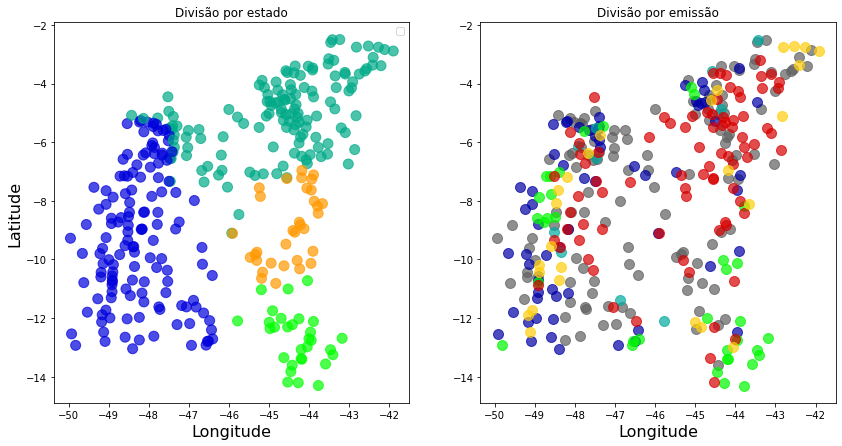

In [16]:
plt.figure(figsize=(14,7))
plt.subplot(121)

color = []
for j in df_graf["States"]:
  if j=="TO":
    i=1
  if j=="MA":
    i=2
  if j=="BA":
    i=3
  if j=="PI":
    i=4
  color.append(cm.nipy_spectral(float(i)/5))

plt.title("Divisão por estado")
plt.ylabel("Latitude",fontsize=16)
plt.scatter(df_graf["long"],df_graf["lat"], s=100, c=color, alpha=0.7) #, s=df_graf['emi_geral_2018']/10000
plt.xlabel("Longitude",fontsize=16)
# plt.ylabel("Latitude",fontsize=16)
plt.legend()



plt.subplot(122)
for i in range(1,7):
  color = correct_color[i-1]
  plt.scatter(df_graf[df_graf.group==i]["long"],df_graf[df_graf.group==i]["lat"], s=100,  color=color, alpha=0.7)#s=df_graf['emi_geral_2018']/10000,
plt.title("Divisão por emissão")
plt.xlabel("Longitude",fontsize=16)



plt.show()


In [17]:
df_graf.count()

States            337
Municipalities    337
emi_2018          337
group_name        337
group             337
pib_2018          337
population        337
Agriculture       337
LUC               337
Energy            337
Waste             337
ID                337
lat               337
long              337
ibge_code         337
dtype: int64

In [18]:
correct_html_color = ['#606060','#0000A5','#00AAA0','#00F900','#D70000','#FFCE0A']

In [19]:
import pandas as pd
import folium
map = folium.Map(location=[df_graf.lat.mean(), df_graf.long.mean()], zoom_start=5, control_scale=True)

for i in range(0,df_graf.shape[0]):

    color = correct_html_color[df_graf.group[i]-1]
    folium.CircleMarker([df_graf.lat[i],
                   df_graf.long[i]],
                       radius=5,
                color=color,
                fill=True,
                fill_color=color,
                popup=str('<i>' +df_graf.Municipalities[i]+ ':' +df_graf.group_name[i]+ '('+str(df_graf.lat[i])+'-'+str(df_graf.long[i])+')'+'</i>')
                  ).add_to(map)

map

In [ ]:
# map.save('/content/map_matopiba.html')

## Adicionando informação de área

In [20]:
df_geo = gpd.read_file('/content/geodata-br/geojson/geojs-100-mun.json')
df_geo.rename(columns={'id':'ibge_code'},inplace=True)
df_geo['ibge_code'] = df_geo['ibge_code'].astype(int)
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ibge_code    5564 non-null   int64   
 1   name         5564 non-null   object  
 2   description  5564 non-null   object  
 3   geometry     5564 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 174.0+ KB


In [21]:
df_graf = df_graf.merge(df_geo,on='ibge_code')

In [22]:
data_graph=df_graf.copy()
data_graph.rename(columns={'ibge_code':'id'},inplace=True)
data_graph['id']=data_graph['id'].astype(str)

In [23]:

color_map= [[1,'rgb(0.3764705882352941, 0.3764705882352941, 0.3764705882352941)'],
 [1,'rgb(0, 0, 0.6470588235294118)'],
 [1,'rgb(0, 0.6666666666666666, 0.6274509803921569)'],
 [1,'rgb(0,  0.9764705882352941, 0)'],
 [1,'rgb(0.8431372549019608, 0, 0)'],
 [1,'rgb(1.0, 0.807843137254902, .0392156862745098)']]


In [42]:
data_map = gpd.read_file('/content/geodata-br/geojson/geojs-100-mun.json')
data_test = data_graph[['group','id','group_name','lat','long',"States",'emi_2018']]
data_map=data_map.merge(data_test,on='id')


In [25]:
xm = [data_map['lat'].min(), data_map['lat'].max()]
ym = [data_map['long'].min(), data_map['long'].max()]

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' o

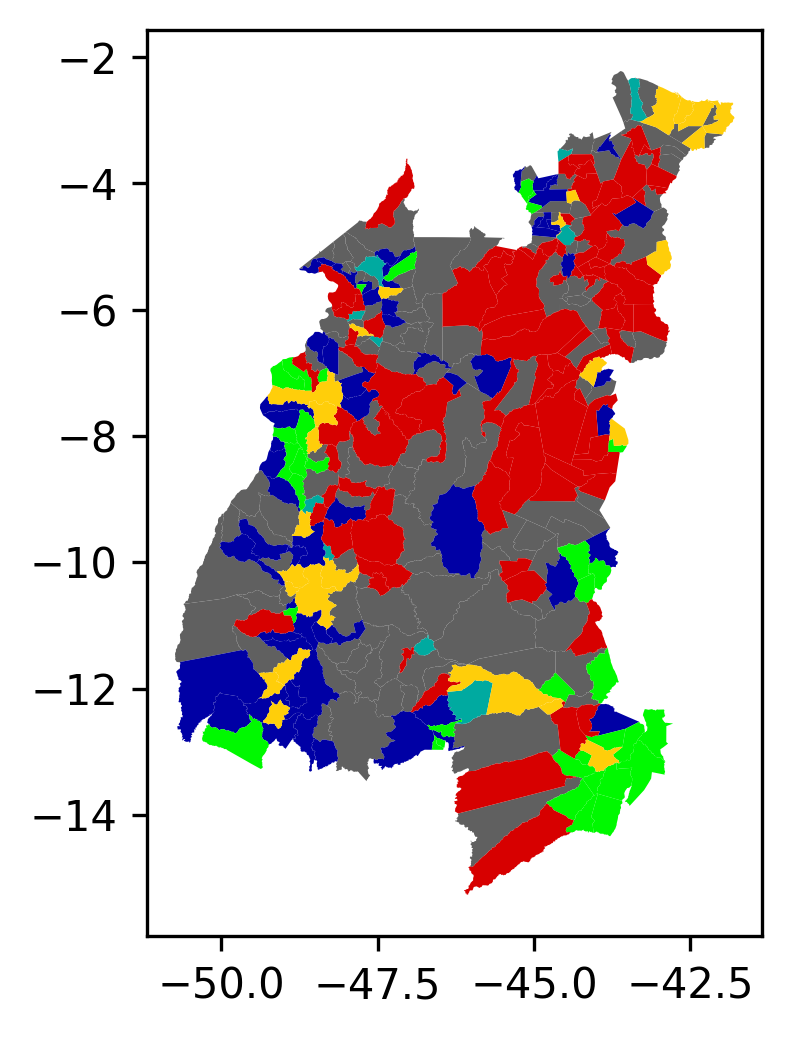

In [26]:
fig, ax = plt.subplots(1, 1,dpi=300)

for i in range(1,7):

  data_map[data_map.group==i].plot(column='group',color=correct_color[i-1],ax=ax,legend=True)

  
  plt.savefig("/content/matopiba_emissions/output/map_group.pdf", format="pdf", dpi=1000)  

## Correlação espacial

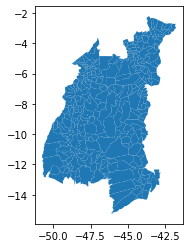

In [27]:
data_map.plot()

In [69]:
centers = np.load('/content/matopiba_emissions/data/clusters_centers.npy')

In [105]:
centers[3]

array([0.75181607, 0.15628909, 0.0565903 , 0.03530455])

In [108]:
centers[0]

C_features=["C_Agriculture","C_LUC","C_Energy","C_Waste"]
C=[]
for group in data_map.group:
  for i in range(1,7):
    if group ==i:
      C.append(centers[group-1])
      # print(centers[group-1],i)
  
C=np.array(C)


In [121]:
for j in range(0,4):
  data_map[C_features[j]] = C[:,j]


In [122]:
data_map.head()

,id,name,description,geometry,group,group_name,lat,long,States,emi_2018,C_Agriculture,C_LUC,C_Energy,C_Waste
0,1700251,Abreulândia,Abreulândia,"POLYGON ((-49.68920 -9.17404, -49.68334 -9.183...",1,G1,-9.62101,-49.1518,TO,415469.12,0.308463,0.623825,0.044368,0.023345
1,1700301,Aguiarnópolis,Aguiarnópolis,"POLYGON ((-47.57606 -6.41434, -47.54211 -6.436...",3,G3,-6.55409,-47.4702,TO,116760.47,0.147048,0.174163,0.606492,0.072296
2,1700350,Aliança do Tocantins,Aliança do Tocantins,"POLYGON ((-48.69558 -11.17521, -48.68797 -11.1...",2,G2,-11.30560,-48.9361,TO,277772.18,0.510702,0.424841,0.043392,0.021065
3,1700400,Almas,Almas,"POLYGON ((-47.26539 -10.97762, -47.26203 -10.9...",1,G1,-11.57060,-47.1792,TO,383090.52,0.308463,0.623825,0.044368,0.023345
4,1700707,Alvorada,Alvorada,"POLYGON ((-49.01914 -12.24278, -49.00430 -12.2...",6,G6,-12.47850,-49.1249,TO,430641.63,0.331592,0.336642,0.257026,0.074740


In [137]:
weights = Queen.from_dataframe(data_map)
W_matrix, ids = weights.full()

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [138]:
weights.transform = 'r'
W_matrix, ids = weights.full()

In [125]:
y = data_map["C_LUC"].copy()
moran = Moran(y, weights)

In [126]:
print(moran.I)
print(moran.permutations)
print(moran.EI_sim)
print(moran.p_sim)

0.3474054870497591
999
-0.003655432444714588
0.001


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff403fd8690>)

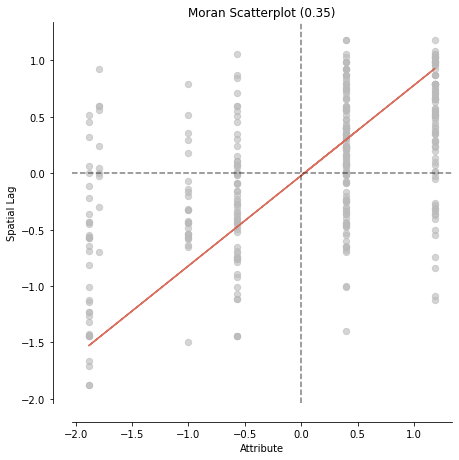

In [127]:
moran_scatterplot(moran)

In [128]:
moran_loc = Moran_Local(y, weights)

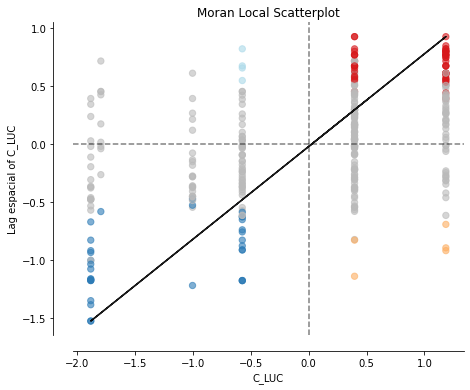

In [129]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('C_LUC')
ax.set_ylabel('Lag espacial of Groups')
plt.show()

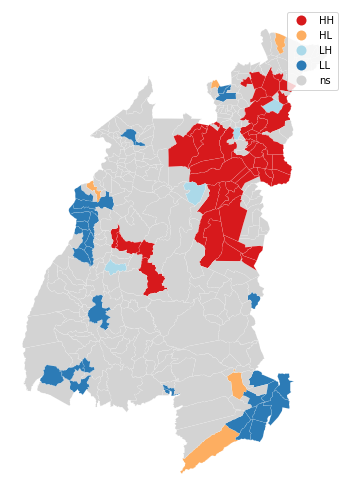

In [130]:
lisa_cluster(moran_loc, data_map, p=0.05, figsize=(9,9))
plt.show()


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


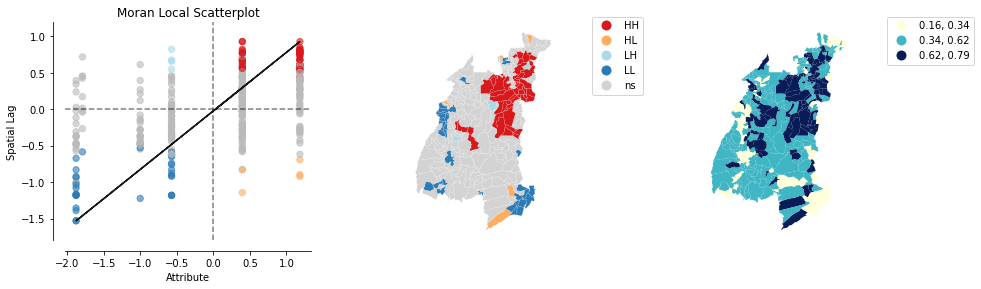

In [132]:
plot_local_autocorrelation(moran_loc, data_map, 'C_LUC')
plt.show()



/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


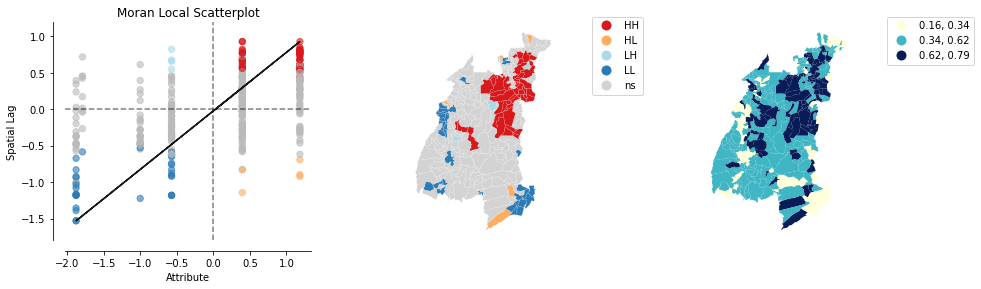

In [133]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, data_map, 'C_LUC')
plt.show()



/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


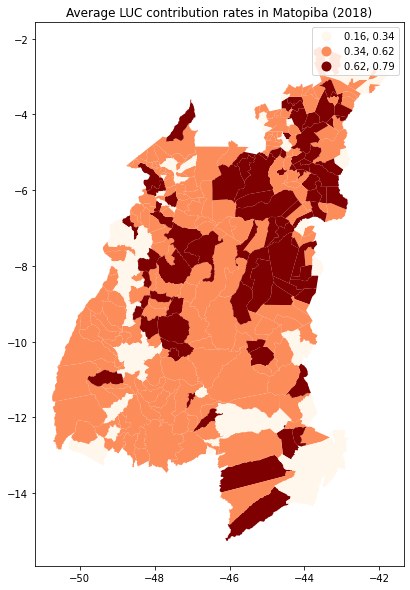

In [134]:
fig = data_map.plot(column='C_LUC', legend=True, figsize=(15, 10), cmap='OrRd', scheme='quantiles')
plt.title("Average LUC contribution rates in Matopiba (2018)")
plt.show()

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


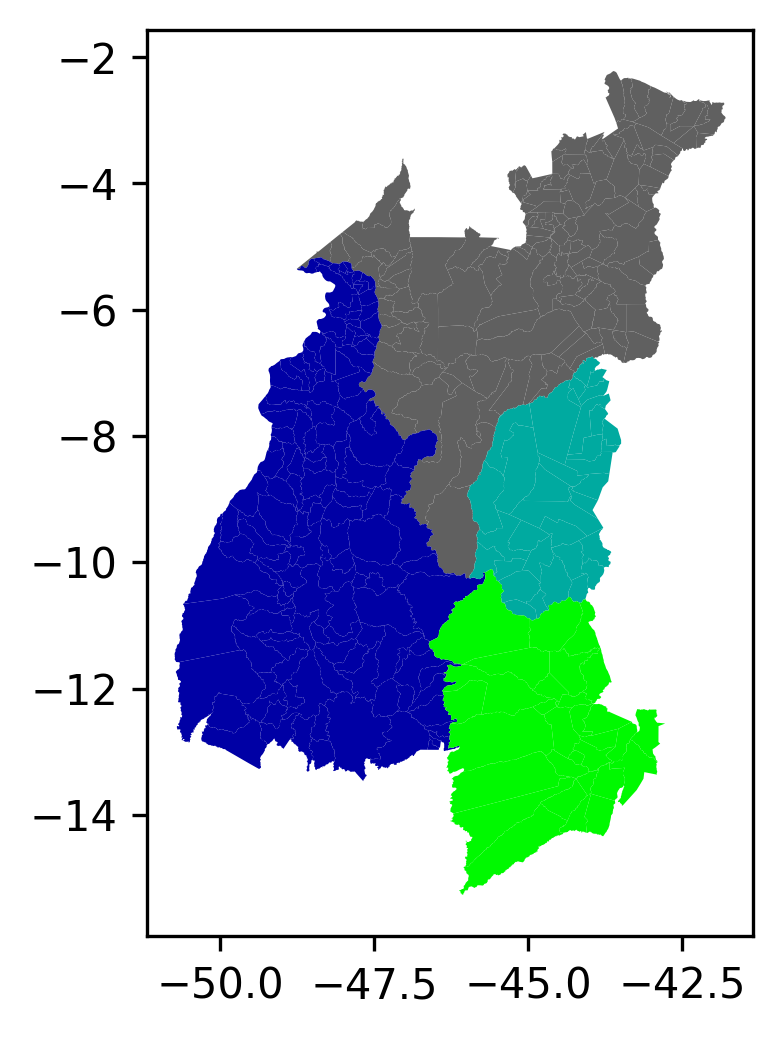

In [ ]:
fig, ax = plt.subplots(1, 1,dpi=300)
# sns.set_theme(context='notebook', style='darkgrid')

sta= ["MA","TO","PI","BA"]

for i in range(0,4):

  data_map[data_map.States==sta[i]].plot(column='States',color=correct_color[i],ax=ax,legend=True)

  
  plt.savefig("/content/matopiba_emissions/output/map_states.pdf", format="pdf", dpi=1000)  